<a href="https://colab.research.google.com/github/Hami4214/EV-car-price-price-prediction-/blob/main/Ev_car_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import files


 Load dataset

In [39]:
data = pd.read_csv('/content/drive/MyDrive/Cheapestelectriccars-EVDatabase.csv')

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Preprocess the data

In [41]:
def extract_numeric(value):
    if isinstance(value, str):
        return float(''.join([c for c in value if c.isdigit() or c == '.']))
    return value

data['Acceleration'] = data['Acceleration'].apply(extract_numeric)
data['TopSpeed'] = data['TopSpeed'].apply(extract_numeric)
data['PriceinGermany'] = data['PriceinGermany'].apply(extract_numeric)
data['PriceinUK'] = data['PriceinUK'].apply(extract_numeric)

Apply exchange rate and tax adjustments
TAX_RATE_GERMANY 19% VAT
TAX_RATE_UK = 0.20, 20% VAT

In [42]:
EXCHANGE_RATE = 0.85  # €1 = £0.85
TAX_RATE_GERMANY = 0.19  # 19% VAT
TAX_RATE_UK = 0.20  # 20% VAT

data['PriceinGermany_Taxed'] = data['PriceinGermany'] * (1 + TAX_RATE_GERMANY)
data['PriceinUK_Converted_Taxed'] = (data['PriceinGermany'] * EXCHANGE_RATE) * (1 + TAX_RATE_UK)

Select relevant columns and drop missing values

In [43]:
cleaned_data = data[['Acceleration', 'TopSpeed', 'PriceinGermany', 'PriceinUK',
                     'PriceinGermany_Taxed', 'PriceinUK_Converted_Taxed']].dropna()

# Feature Engineering:

In [44]:
cleaned_data['Acc_Speed_Ratio'] = cleaned_data['Acceleration'] / cleaned_data['TopSpeed']

# Compute and display correlation matrix

In [56]:
correlation_matrix = cleaned_data.corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                           Acceleration  TopSpeed  PriceinGermany  PriceinUK  \
Acceleration                   1.000000 -0.839637       -0.690798  -0.718233   
TopSpeed                      -0.839637  1.000000        0.838137   0.869518   
PriceinGermany                -0.690798  0.838137        1.000000   0.984674   
PriceinUK                     -0.718233  0.869518        0.984674   1.000000   
PriceinGermany_Taxed          -0.690798  0.838137        1.000000   0.984674   
PriceinUK_Converted_Taxed     -0.690798  0.838137        1.000000   0.984674   
Acc_Speed_Ratio                0.985290 -0.833790       -0.657316  -0.689899   

                           PriceinGermany_Taxed  PriceinUK_Converted_Taxed  \
Acceleration                          -0.690798                  -0.690798   
TopSpeed                               0.838137                   0.838137   
PriceinGermany                         1.000000                   1.000000   
PriceinUK                  

 # Correlation Heatmap

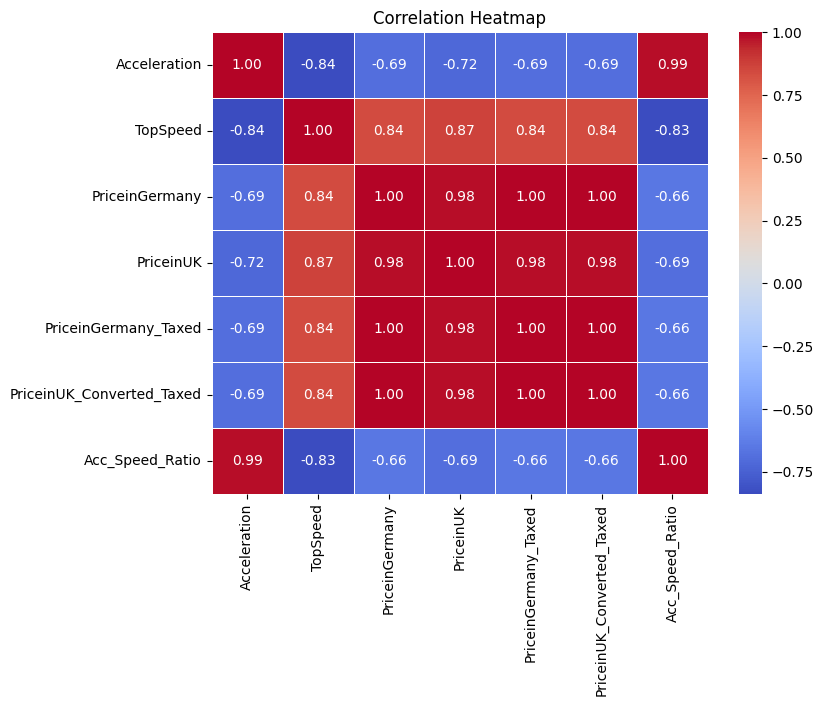

In [45]:
plt.figure(figsize=(8, 6))
sns.heatmap(cleaned_data.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

#  Scatter Plots

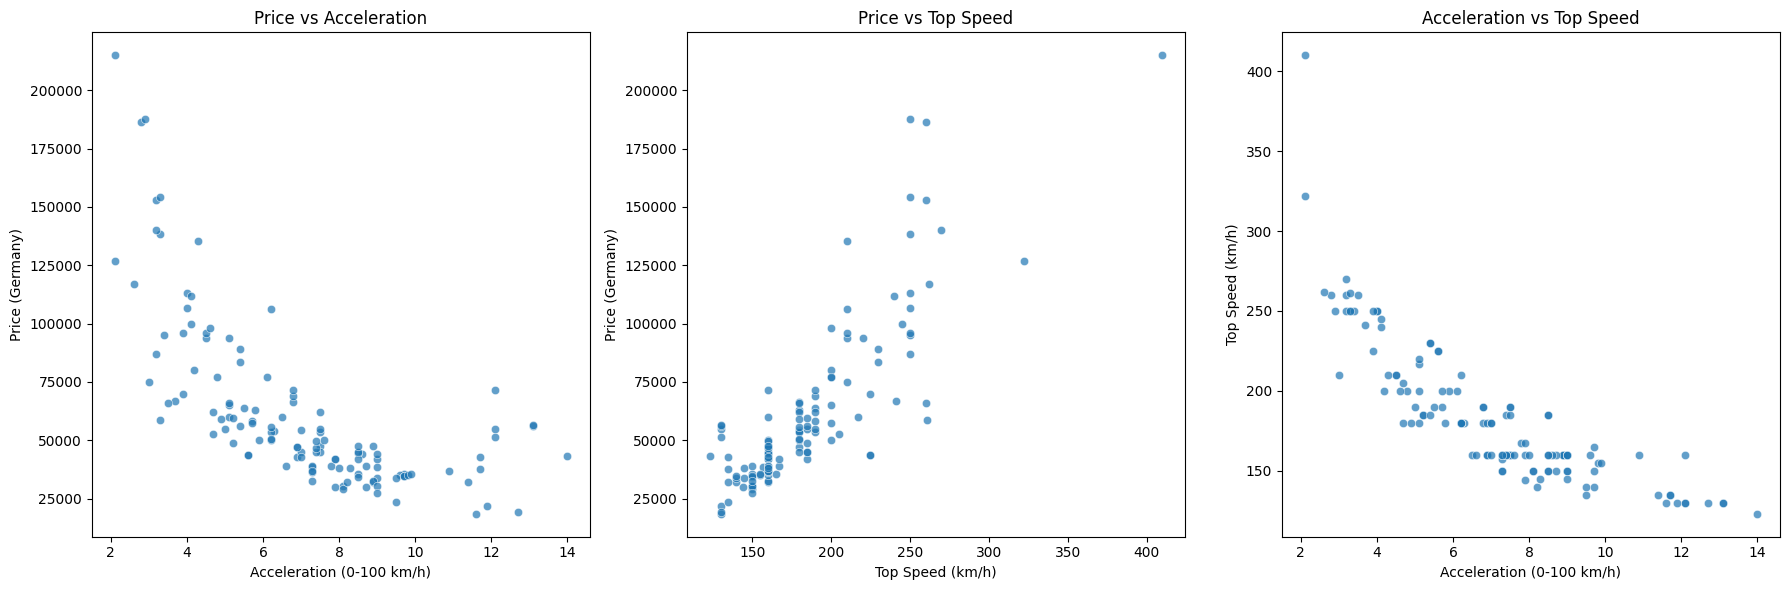

In [46]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.scatterplot(data=cleaned_data, x='Acceleration', y='PriceinGermany', alpha=0.7)
plt.title('Price vs Acceleration')
plt.xlabel('Acceleration (0-100 km/h)')
plt.ylabel('Price (Germany)')

plt.subplot(1, 3, 2)
sns.scatterplot(data=cleaned_data, x='TopSpeed', y='PriceinGermany', alpha=0.7)
plt.title('Price vs Top Speed')
plt.xlabel('Top Speed (km/h)')
plt.ylabel('Price (Germany)')

plt.subplot(1, 3, 3)
sns.scatterplot(data=cleaned_data, x='Acceleration', y='TopSpeed', alpha=0.7)
plt.title('Acceleration vs Top Speed')
plt.xlabel('Acceleration (0-100 km/h)')
plt.ylabel('Top Speed (km/h)')

plt.tight_layout()
plt.show()

# Prepare data for modeling

In [47]:
X = cleaned_data[['Acceleration', 'TopSpeed', 'Acc_Speed_Ratio']]
y_germany_raw = cleaned_data['PriceinGermany']
y_uk_raw = cleaned_data['PriceinUK']
y_germany_taxed = cleaned_data['PriceinGermany_Taxed']
y_uk_taxed = cleaned_data['PriceinUK_Converted_Taxed']

# Standardize features

In [48]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data

In [49]:
def split_data(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train_raw_germany, X_test_raw_germany, y_train_raw_germany, y_test_raw_germany = split_data(X_scaled, y_germany_raw)
X_train_taxed_germany, X_test_taxed_germany, y_train_taxed_germany, y_test_taxed_germany = split_data(X_scaled, y_germany_taxed)
X_train_raw_uk, X_test_raw_uk, y_train_raw_uk, y_test_raw_uk = split_data(X_scaled, y_uk_raw)
X_train_taxed_uk, X_test_taxed_uk, y_train_taxed_uk, y_test_taxed_uk = split_data(X_scaled, y_uk_taxed)

# Initialize models

In [50]:
linear_model = LinearRegression()
random_forest = RandomForestRegressor(random_state=42)
gradient_boosting = GradientBoostingRegressor(random_state=42)

# Function for training, evaluation, and visualizations

In [54]:
   def train_and_evaluate(X_train, X_test, y_train, y_test, label):
    # Train models
    linear_model.fit(X_train, y_train)
    random_forest.fit(X_train, y_train)
    gradient_boosting.fit(X_train, y_train)

    # Evaluate models
    predictions_linear = linear_model.predict(X_test)
    predictions_rf = random_forest.predict(X_test)
    predictions_gb = gradient_boosting.predict(X_test)

    print(f"\nPerformance Metrics for {label}:")
    for name, predictions in zip(
        ["Linear Regression", "Random Forest", "Gradient Boosting"],
        [predictions_linear, predictions_rf, predictions_gb]
    ):
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        print(f"{name} - MSE: {mse:.2f}, R²: {r2:.2f}")

    # Feature Importance (Random Forest)
    feature_importance = random_forest.feature_importances_
    plt.barh(X.columns, feature_importance, color='teal')
    plt.title(f"Feature Importance ({label})")
    plt.xlabel("Importance Score")
    plt.show()

    # Predicted vs. True Prices
    plt.scatter(y_test, predictions_rf, alpha=0.7, label="Random Forest")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f"Predicted vs True Prices ({label})")
    plt.xlabel("True Prices")
    plt.ylabel("Predicted Prices")
    plt.legend()
    plt.show()

# Train and evaluate models


Performance Metrics for Germany (Raw Prices):
Linear Regression - MSE: 369971408.09, R²: 0.63
Random Forest - MSE: 487707487.93, R²: 0.52
Gradient Boosting - MSE: 473158518.59, R²: 0.53


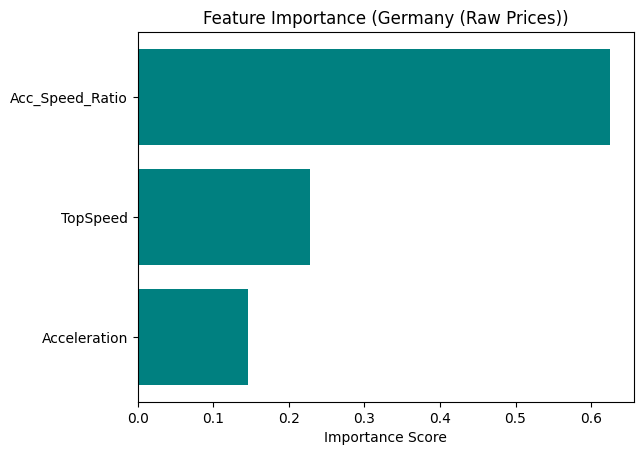

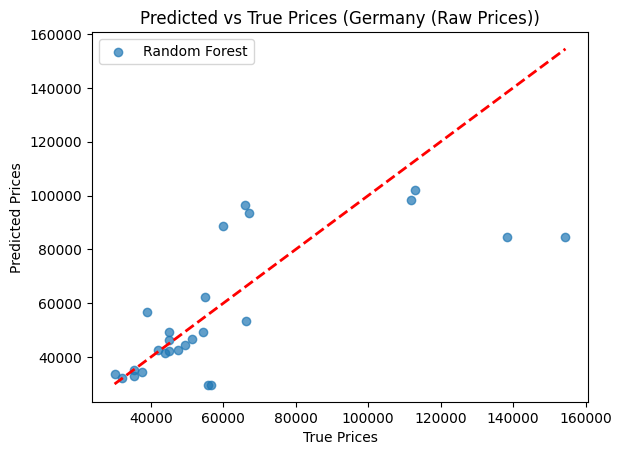


Performance Metrics for Germany (Taxed Prices):
Linear Regression - MSE: 523916511.00, R²: 0.63
Random Forest - MSE: 672490319.64, R²: 0.53
Gradient Boosting - MSE: 677199926.27, R²: 0.52


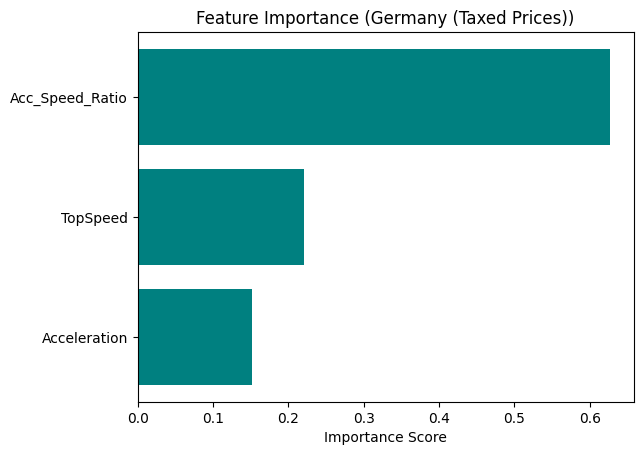

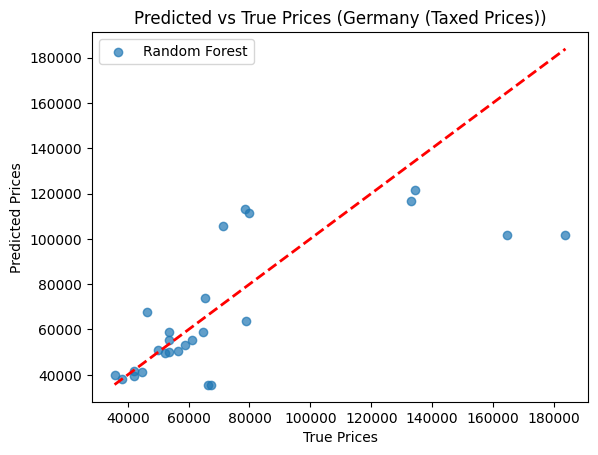


Performance Metrics for UK (Raw Prices):
Linear Regression - MSE: 212577034.50, R²: 0.63
Random Forest - MSE: 224966938.00, R²: 0.61
Gradient Boosting - MSE: 220924208.40, R²: 0.62


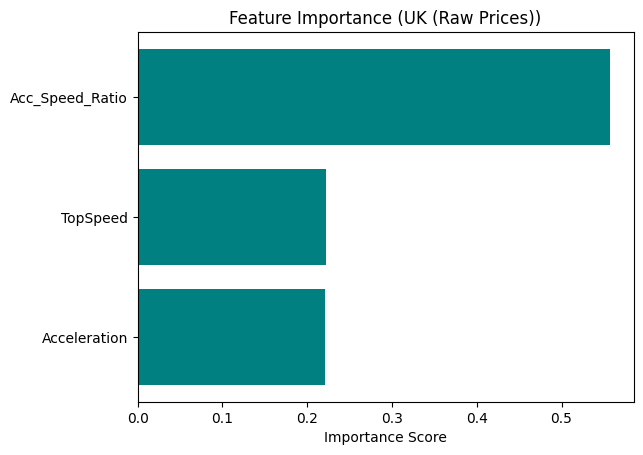

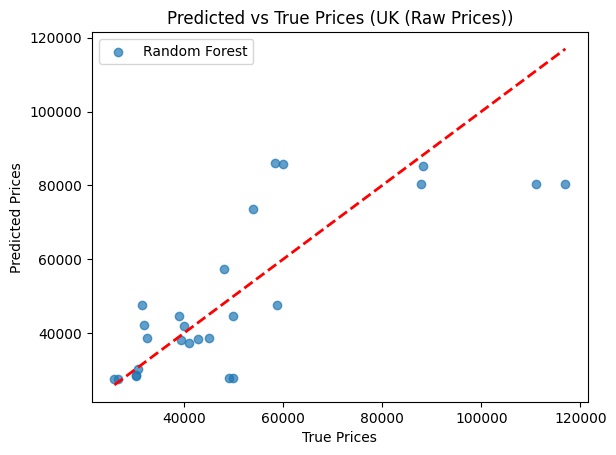


Performance Metrics for UK (Taxed Prices):
Linear Regression - MSE: 384918252.98, R²: 0.63
Random Forest - MSE: 494853175.05, R²: 0.53
Gradient Boosting - MSE: 494047878.05, R²: 0.53


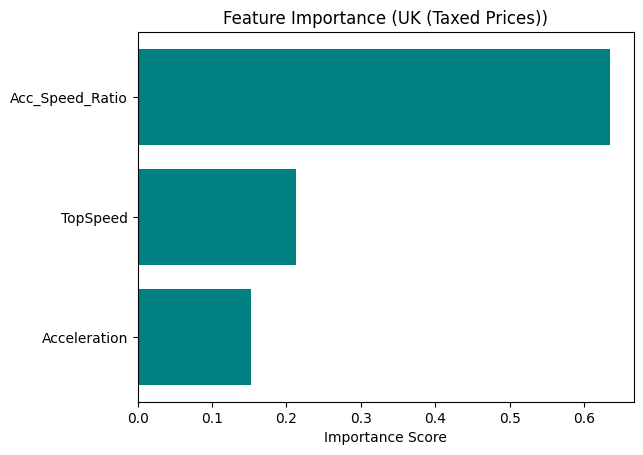

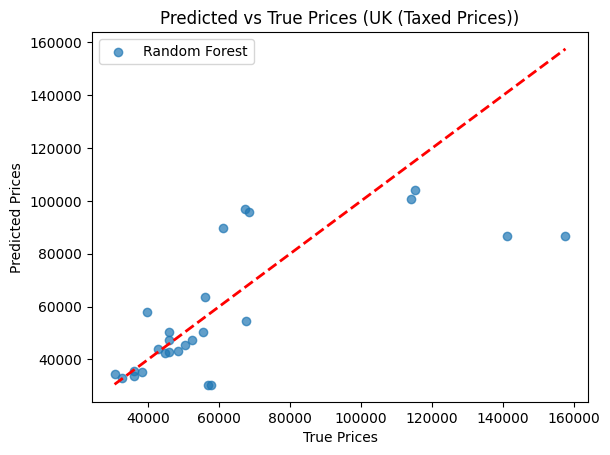

In [55]:
train_and_evaluate(X_train_raw_germany, X_test_raw_germany, y_train_raw_germany, y_test_raw_germany, "Germany (Raw Prices)")
train_and_evaluate(X_train_taxed_germany, X_test_taxed_germany, y_train_taxed_germany, y_test_taxed_germany, "Germany (Taxed Prices)")
train_and_evaluate(X_train_raw_uk, X_test_raw_uk, y_train_raw_uk, y_test_raw_uk, "UK (Raw Prices)")
train_and_evaluate(X_train_taxed_uk, X_test_taxed_uk, y_train_taxed_uk, y_test_taxed_uk, "UK (Taxed Prices)")